# Proyecto 2
## Bioseñales y sistemas. 2024
### María J. Ostos, Cristian Florez, Juan A. Sañudo


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import scipy.signal as signal 
from scipy.fftpack import fft
from scipy.signal import detrend
from scipy.fftpack import fft
from numpy.polynomial.polynomial import Polynomial

# import os

In [7]:
ruta="./otros/Diagnostics.xlsx"
df = pd.read_excel(ruta)

# Crear el nuevo dataframe filtrando por la columna 'Rhythm'
datos = df[(df['Rhythm'] == 'SB') | (df['Rhythm'] == 'AFIB')]

#Tamaño del nuevo dataframe
datos.shape

fs=500
tiempo = np.arange(0, datos.shape[0]/fs,1/fs)

datos.head()

,FileName,Rhythm,Beat,PatientAge,Gender,VentricularRate,AtrialRate,QRSDuration,QTInterval,QTCorrected,RAxis,TAxis,QRSCount,QOnset,QOffset,TOffset
0,MUSE_20180113_171327_27000,AFIB,RBBB TWC,85,MALE,117,234,114,356,496,81,-27,19,208,265,386
1,MUSE_20180112_073319_29000,SB,TWC,59,FEMALE,52,52,92,432,401,76,42,8,215,261,431
3,MUSE_20180113_121940_44000,SB,NONE,66,MALE,53,53,96,456,427,34,3,9,219,267,447
5,MUSE_20180112_120347_79000,SB,NONE,46,FEMALE,57,57,70,404,393,38,24,9,225,260,427
6,MUSE_20180114_075026_69000,AFIB,TWC,80,FEMALE,98,86,74,360,459,69,83,17,215,252,395


In [8]:
tiempo.shape, datos.shape

((5669,), (5669, 16))

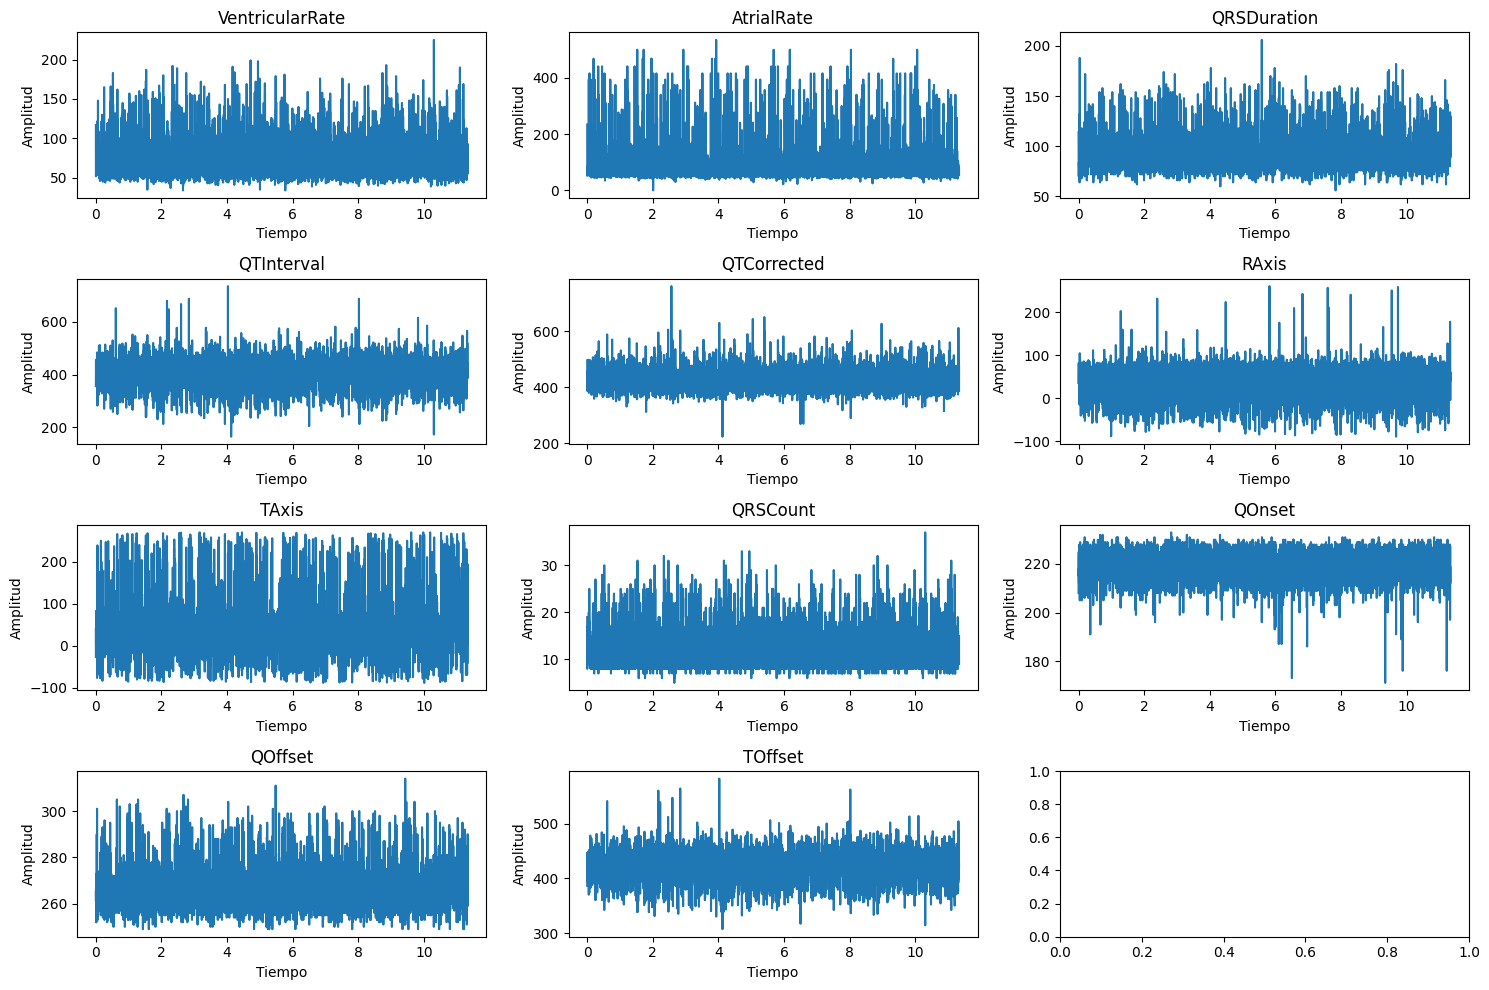

In [9]:
# Definir las columnas que quieres graficar
start_col = 5  # Columna 6 (índice 5)
end_col = 15   # Última columna (índice 15)

# Calcular el número de señales a graficar
num_signals = end_col - start_col   # Número de columnas desde la 6 hasta la última
cols = 3  # Número de columnas que quieres en la figura

# Calcular el número de filas necesarias
if (num_signals % cols) != 0:
    rows = num_signals // cols + 1  # Añadir una fila extra si hay resto
else:
    rows = num_signals // cols  # Si no hay resto, las filas son exactas

# Crear una figura con el número de filas y columnas calculado
fig, axs = plt.subplots(rows, cols, figsize=(15, 10))

# Seleccionar las columnas que se van a graficar desde 'start_col' hasta 'end_col'
columns = datos.columns[start_col:end_col + 1]  # +1 para incluir la última columna

# Ajustar el espaciado entre los subplots
# plt.subplots_adjust(hspace=0.6, wspace=0.4)

# x=np.zeros(len(datos["QOffset"]))

# Graficar cada columna en su subplot correspondiente
for i in range(rows):  # Recorrer las filas
    for j in range(cols):  # Recorrer las columnas
        col_index = i * cols + j  # Índice para las columnas seleccionadas
        if col_index < len(columns):  # Verificar si hay suficientes columnas
            col_name = columns[col_index]  # Obtener el nombre de la columna actual
            axs[i, j].plot(tiempo,datos[col_name])  # Graficar la columna actual
            # axs[i, j].plot(tiempo,x,label='Señal con Detrend', color='red')  # Graficar la columna actual
            axs[i, j].set_title(f'{col_name}')  # Título con el nombre de la columna
            axs[i, j].set_xlabel('Tiempo')  # Etiqueta del eje X
            axs[i, j].set_ylabel('Amplitud')  # Etiqueta del eje Y

plt.tight_layout()
# Mostrar la figura con los subplots
plt.show()


### Ecuación 1

In [46]:
def detrending(data, grado=20):
    """
    Realiza el detrending de las señales en las columnas 7 a 16 de un dataframe usando un ajuste polinómico de grado 20.
    Retorna el dataframe con las señales detrendizadas y la desviación calculada.
    """
    for col in data.columns[5:]:
        x = data[col].values
        # Ajustar el polinomio de grado 20
        p = Polynomial.fit(np.arange(len(x)), x, grado)
        # Restar la tendencia polinómica
        detrended_signal = x - p(np.arange(len(x)))
        # Calcular la desviación (δ(n))
        deviation = np.mean((x - detrended_signal)**2)
        # Reemplazar la columna con la señal detrendizada
        data[col] = detrended_signal
        print(f'Desviación para la columna {col}: {deviation}')
    return data


# def eq_deviation(x0): #x0 original, xn detrended, k tamaña señal
#     xn=x0.copy()
#     cols_to_detrend = x0.columns[5:]  # Seleccionamos desde la columna 6 en adelante

#     # Aplicamos detrend a cada columna seleccionada
#     for col in cols_to_detrend:
#         xn[col] = signal.detrend(x0[col])

#     resultado = np.mean((x0[cols_to_detrend] - xn[cols_to_detrend]) ** 2)
    

#     return resultado


### Ecuación 2


In [47]:
def compression(data):
    """
    Aplica la compresión a las señales en las columnas 6 a 16, escalando los valores en el rango (0, 1).
    """
    for col in data.columns[5:]:
        x = data[col].values
        # Encontrar los valores máximos y mínimos de la señal
        xmin, xmax = np.min(x), np.max(x)
        # Comprimir la señal
        compressed_signal = (x - xmin) / (xmax - xmin)
        # Reemplazar la columna con la señal comprimida
        data[col] = compressed_signal
    
    return data

# def compress(df, start_col):
#     # Copiamos el DataFrame para no modificar el original
#     compressed_df = df.copy()
    
#     # Aplicamos la compresión desde la columna start_col hasta el final
#     for col in compressed_df.columns[start_col:]:
#         signal = pd.to_numeric(compressed_df[col], errors='coerce')  # Convertimos a numérico, ignoramos strings
#         signal_cleaned = signal.dropna()

#         if len(signal_cleaned) > 0:
#             xmin = np.min(signal_cleaned)  # Valor mínimo
#             xmax = np.max(signal_cleaned)  # Valor máximo
            
#             if xmax != xmin:
#                 # Aplicamos la fórmula de compresión solo si xmax es diferente de xmin
#                 compressed_df[col] = (signal - xmin) / (xmax - xmin)
#             else:
#                 # Si no hay rango (xmin == xmax), llenamos con ceros
#                 compressed_df[col] = 0
#         else:
#             # Si no hay valores válidos, llenamos con NaN
#             compressed_df[col] = np.nan
            
#     return compressed_df

### Ecuación 3 y 4

In [61]:
# Función 3 ajustada: Bispectrum y Bicoherence con ventana de superposición
def bispectrum_bicoherence(data, segment_length=8192, overlap=0.5):
    """
    Calcula el bispectrum y la bicoherencia de las señales en las columnas 5 a 16 con ventana de superposición.
    overlap: porcentaje de superposición entre los segmentos (e.g., 0.5 para 50%).
    """
    step = int(segment_length * (1 - overlap))  # Tamaño del paso entre segmentos
    # print(f'ventana {step}\n')
    for col in data.columns[5:]:
        x = data[col].values
        # Crear los segmentos con solapamiento
        segments = [x[i:i+segment_length] for i in range(0, len(x) - segment_length + 1, step)]
        bispectrum_sum = 0
        bicoherence_sum = 0
        N = len(segments)
        
        # Calcular la FFT para cada segmento y luego calcular bispectrum y bicoherence
        for segment in segments:
            X = fft(segment)
            f1_f2_pairs = [(f1, f2) for f1 in range(len(X)//2) for f2 in range(f1, len(X)//2) if f1 + f2 < len(X)//2]
            for f1, f2 in f1_f2_pairs:
                bispectrum_sum += X[f1] * X[f2] * np.conj(X[f1 + f2])
                bicoherence_sum += np.abs(X[f1] * X[f2] * np.conj(X[f1 + f2]))
        
        bispectrum = bispectrum_sum / N
        bicoherence = np.abs(bispectrum_sum) / bicoherence_sum if bicoherence_sum != 0 else 0
        
        print(f'Bicoherencia para la columna {col}: {bicoherence}')
    
    return data


# def bispectrum_bicoherence(data, segment_length=2048):
#     """
#     Calcula el bispectrum y la bicoherencia de las señales en las columnas 6 a 16.
#     """
#     for col in data.columns[5:]:
#         x = data[col].values
#         # Dividir los datos en segmentos
#         segments = [x[i:i+segment_length] for i in range(0, len(x), segment_length) if len(x[i:i+segment_length]) == segment_length]
#         bispectrum_sum = 0
#         bicoherence_sum = 0
#         N = len(segments)
        
#         # Calcular la FFT para cada segmento y luego calcular bispectrum y bicoherence
#         for segment in segments:
#             X = fft(segment)
#             f1_f2_pairs = [(f1, f2) for f1 in range(len(X)//2) for f2 in range(f1, len(X)//2) if f1 + f2 < len(X)//2]
#             for f1, f2 in f1_f2_pairs:
#                 bispectrum_sum += X[f1] * X[f2] * np.conj(X[f1 + f2])
#                 bicoherence_sum += np.abs(X[f1] * X[f2] * np.conj(X[f1 + f2]))
        
#         bispectrum = bispectrum_sum / N
#         bicoherence = np.abs(bispectrum_sum) / bicoherence_sum if bicoherence_sum != 0 else 0
        
#         print(f'Bicoherencia para la columna {col}: {bicoherence}')
    
#     return data

In [63]:
def process_signals(df):
    """
    Aplica las funciones de detrending, compresión y análisis espectral a las columnas 6 a 16 del dataframe.
    """
    numero=df.shape[0]
    n = 0
    potencia = 2**n

    while potencia <= numero:
        n += 1
        potencia = 2**n

    segm=2**(n-1)
    print(f'Tamaño de segmento a usar {segm} \n')

    print("Aplicando detrending...\n")
    df = detrending(df)

    print("\nAplicando compresión...\n")
    df = compression(df)

    print("Calculando bispectrum y bicoherence...\n")
    df = bispectrum_bicoherence(df,segment_length=segm)

    print("Procesamiento completo.")
    return df



In [62]:
# Procesar las señales del DataFrame
df_processed = process_signals(datos)

Tamaño de segmento a usar 4096 

Aplicando detrending...

Desviación para la columna VentricularRate: 0.03172824098911684
Desviación para la columna AtrialRate: 0.02310644675606202
Desviación para la columna QRSDuration: 0.06509958296823991
Desviación para la columna QTInterval: 0.18187157713463928
Desviación para la columna QTCorrected: 0.1429275612110925
Desviación para la columna RAxis: 0.13020474682696873
Desviación para la columna TAxis: 0.13648658842664294
Desviación para la columna QRSCount: 0.03512299540769501
Desviación para la columna QOnset: 0.602907924411688
Desviación para la columna QOffset: 0.07007811693440753
Desviación para la columna TOffset: 0.17828238418577422
Aplicando compresión...

Calculando bispectrum y bicoherence...

ventana 2048

Bicoherencia para la columna VentricularRate: 0.5671326171037815
Bicoherencia para la columna AtrialRate: 0.5157018378742514
Bicoherencia para la columna QRSDuration: 0.8440871524184927
Bicoherencia para la columna QTInterval: 0.975

# Prueba

In [71]:
# import numpy as np
# import pandas as pd
# from scipy.signal import detrend
# from scipy.fftpack import fft

# ... (resto de tus funciones)

def process_signals(df):
    # ... (resto de tu código)

    results = []
    for col in df.columns[5:]:
        x = df[col].values
        X = fft(x)
        freqs = np.fft.fftfreq(len(x))

        # Frecuencia de máxima potencia
        idx = np.argmax(np.abs(X))
        fMP = freqs[idx]

        # Frecuencias significativas para bicoherencia
        N = len(x)
        threshold = np.sqrt(9.2 / (2 * N))
        significant_freqs = np.sum(np.abs(X) > threshold)

        # Almacenar resultados
        results.append([col, fMP, significant_freqs])

    # Crear DataFrame con los resultados
    results_df = pd.DataFrame(results, columns=['registro', 'fMP', 'sFSB'])

    return results_df

In [72]:
# Procesar las señales del DataFrame
df_processed = process_signals(datos)

In [68]:
df_processed

,registro,fMP,sFSB
0,VentricularRate,0.0,5661
1,AtrialRate,0.0,5661
2,QRSDuration,0.0,5661
3,QTInterval,0.0,5661
4,QTCorrected,0.0,5659
5,RAxis,0.0,5659
6,TAxis,0.0,5661
7,QRSCount,0.0,5661
8,QOnset,0.0,5661
9,QOffset,0.0,5661
